In [1]:
!pip install openai rdflib networkx matplotlib --quiet


You should consider upgrading via the 'C:\projects\test_prototypes\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install openai

You should consider upgrading via the 'C:\projects\test_prototypes\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import sys
print(sys.executable)


c:\projects\test_prototypes\venv\Scripts\python.exe


In [ ]:

import os
import uuid
from pathlib import Path
import openai
from rdflib import Graph, URIRef, Literal, Namespace, RDF
import networkx as nx
import matplotlib.pyplot as plt
import my_config 
import os, json, time
from pathlib import Path
from openai import OpenAI, RateLimitError

openai.api_key = my_config.OPENAI_API_KEY  


In [16]:
def load_documents(folder_path="./documents"):
    data = []
    for file_path in Path(folder_path).glob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.read().split("\n")
            title = lines[0].replace("Document title: ", "").strip()
            text = "\n".join(lines[3:]).replace("Text: ", "").strip()
            data.append({
                "filename": file_path.name,
                "title": title,
                "text": text
            })
    return data

documents = load_documents()
print(f"📁 Loaded {len(documents)} Thuisdokter files")


📁 Loaded 13256 Thuisdokter files


In [14]:
print(documents[0])

{'filename': '41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-0.txt', 'title': 'Ik ben 41 weken zwanger en ik kan kiezen tussen afwachten en mijn bevalling laten starten', 'text': 'Soms ben je bij 41 weken zwangerschap nog niet bevallen.Je kunt dan kiezen uit:afwachten of je bevalling vanzelf begintje bevalling laten startenDe ene keuze is niet beter dan de andere keuze.Je kunt met je verloskundige of gynaecoloog bespreken welke keuze het beste bij je past.'}


In [18]:
def safe_extract_triples(text, model="gpt-3.5-turbo", max_retries=3, delay=5):
    prompt = f"""
Je bent een medische kennis-extractie assistent. Haal uit onderstaande tekst duidelijke kennisdriehoeken (subject, relatie, object).

Tekst:
{text}

Formaat:
[("subject1", "relatie1", "object1"), ("subject2", "relatie2", "object2"), ...]

Antwoord:
"""
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
            )
            content = response.choices[0].message.content.strip()
            return eval(content)
        except RateLimitError:
            print(f"⚠️ Rate limit hit. Waiting {delay} seconds...")
            time.sleep(delay)
        except Exception as e:
            print(f"❌ Error: {e}")
            return []
    return []


In [19]:
OUTPUT_PATH = "thuisdokterapp/processed_triples.jsonl"

def already_processed():
    if not os.path.exists(OUTPUT_PATH):
        return set()
    with open(OUTPUT_PATH, "r") as f:
        return {json.loads(line)["filename"] for line in f}

processed_files = already_processed()
print(f"✅ Skipping {len(processed_files)} files already processed.")


✅ Skipping 0 files already processed.


In [20]:
with open(OUTPUT_PATH, "a", encoding="utf-8") as out_f:
    for doc in documents:
        if doc["filename"] in processed_files:
            continue

        print(f"🔍 Processing: {doc['filename']}")
        triples = safe_extract_triples(doc["text"])

        out_f.write(json.dumps({
            "filename": doc["filename"],
            "title": doc["title"],
            "triples": triples
        }) + "\n")

        # Add to processed_files to avoid duplicates if re-run in same session
        processed_files.add(doc["filename"])

        time.sleep(1.5)  # Respect rate limits (safe zone)


🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-0.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-1.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-2.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-3.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-4.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-5.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-kan-kiezen-tussen-afwachten-en-mijn-bevalling-laten-6.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-wil-afwachten-of-mijn-bevalling-vanzelf-begint-0.txt
🔍 Processing: 41-weken-zwangerik-ben-41-weken-zwanger-en-ik-w

In [23]:
from rdflib import Graph, URIRef, Namespace
from urllib.parse import quote
import json

def sanitize_uri_part(text):
    if not text:
        return None
    text = text.strip().lower()
    return quote(text.replace(" ", "_").replace("/", "_"))

def jsonl_to_rdf(jsonl_path="thuisdokterapp/processed_triples.jsonl", ttl_output="thuisdokter_graph.ttl"):
    g = Graph()
    EX = Namespace("http://example.org/")
    skipped = 0

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, start=1):
            try:
                entry = json.loads(line)
                for triple in entry.get("triples", []):
                    if isinstance(triple, (list, tuple)) and len(triple) == 3:
                        subj, pred, obj = triple
                        if not subj or not pred or not obj:
                            raise ValueError("Triple contains None or empty string")
                        
                        s = URIRef(EX[sanitize_uri_part(subj)])
                        p = URIRef(EX[sanitize_uri_part(pred)])
                        o = URIRef(EX[sanitize_uri_part(obj)])
                        g.add((s, p, o))
                    else:
                        raise ValueError("Triple is not a list of 3 items")
            except Exception as e:
                print(f"⚠️ Line {line_num} skipped: {e}")
                skipped += 1

    g.serialize(destination=ttl_output, format="turtle")
    print(f"✅ RDF exported to: {ttl_output}")
    print(f"🚫 Skipped {skipped} malformed triples")

jsonl_to_rdf()


⚠️ Line 13 skipped: Triple is not a list of 3 items
⚠️ Line 25 skipped: Triple is not a list of 3 items
⚠️ Line 33 skipped: Triple is not a list of 3 items
⚠️ Line 37 skipped: Triple is not a list of 3 items
⚠️ Line 43 skipped: Triple is not a list of 3 items
⚠️ Line 49 skipped: Triple contains None or empty string
⚠️ Line 50 skipped: Triple is not a list of 3 items
⚠️ Line 56 skipped: Triple is not a list of 3 items
⚠️ Line 58 skipped: Triple contains None or empty string
⚠️ Line 60 skipped: Triple contains None or empty string
⚠️ Line 68 skipped: Triple contains None or empty string
⚠️ Line 70 skipped: Triple is not a list of 3 items
⚠️ Line 74 skipped: Triple is not a list of 3 items
⚠️ Line 78 skipped: Triple is not a list of 3 items
⚠️ Line 80 skipped: Triple is not a list of 3 items
⚠️ Line 85 skipped: Triple is not a list of 3 items
⚠️ Line 96 skipped: Triple contains None or empty string
⚠️ Line 99 skipped: Triple is not a list of 3 items
⚠️ Line 102 skipped: Triple is not a li

c:\projects\test_prototypes\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


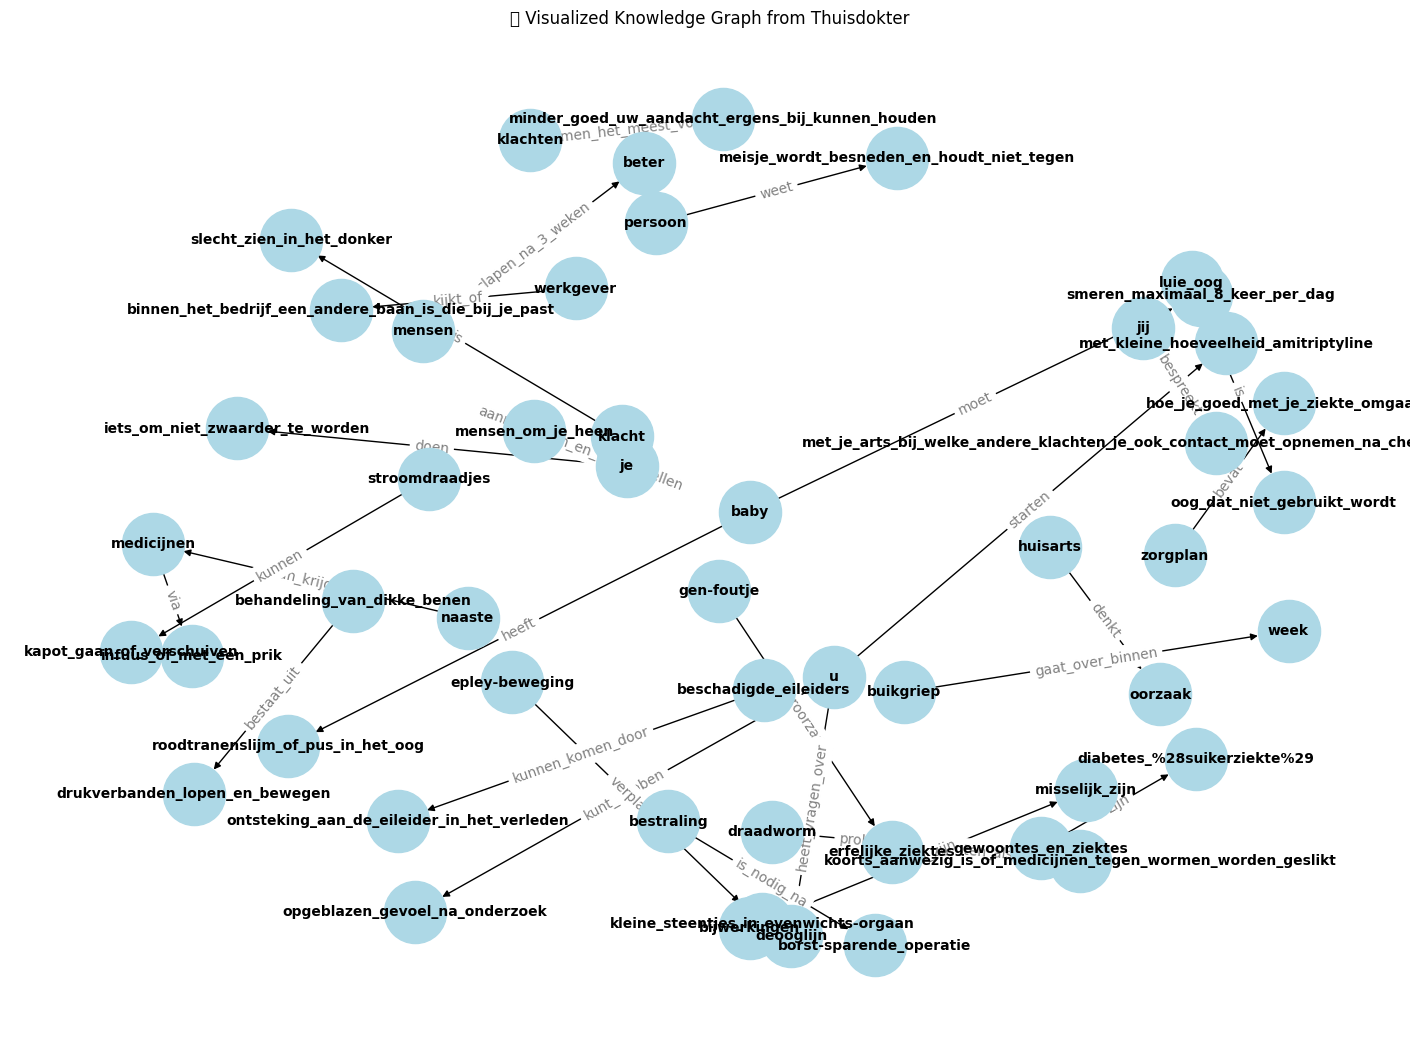

In [24]:
def visualize_graph(rdf_path="thuisdokter_graph.ttl", max_nodes=50):
    g = Graph()
    g.parse(rdf_path, format="turtle")

    nxg = nx.DiGraph()

    for subj, pred, obj in g:
        nxg.add_edge(subj.split("/")[-1], obj.split("/")[-1], label=pred.split("/")[-1])
        if nxg.number_of_nodes() >= max_nodes:
            break

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(nxg, k=0.5)

    nx.draw(nxg, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
    edge_labels = nx.get_edge_attributes(nxg, 'label')
    nx.draw_networkx_edge_labels(nxg, pos, edge_labels=edge_labels, font_color='gray')

    plt.title("🔍 Visualized Knowledge Graph from Thuisdokter")
    plt.axis("off")
    plt.show()

visualize_graph()
